In [43]:
import scanpy as sc
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# Load the data

In [66]:
adata = sc.read_csv('seurat_ST1_counts.csv')
adata = adata.transpose()
adata

AnnData object with n_obs × n_vars = 4095 × 36601

In [67]:
obs = pd.read_csv('data/seurat_ST1_obs.csv', sep = ' ')
obs.columns = ['in_tissue', 'array_row', 'array_col']
adata.obs = obs.copy()

In [68]:
obsm = pd.read_csv('data/seurat_ST1_obsm.csv', sep = ' ')
obsm = np.array(obsm)
obsm_list = list()
for i in range(len(obsm)):
    obsm_list.append([obsm[i][1], obsm[i][0]])
np.array(obsm_list)

adata.obsm['spatial'] = np.array(obsm_list)

In [69]:
adata.uns['spatial'] = {'ST1': {'images': { 'hires': np.array([], dtype=np.float32),
                                     'lowres': np.array([], dtype=np.float32)},
                          'scalefactors': {
                              'spot_diameter_fullres': 0,
                              'tissue_hires_scalef': 0,
                              'fiducial_diameter_fullres': 0,
                              'tissue_lowres_scalef': 0},
                          'metadata': {
                              'chemistry_description': "",
                              'software_version': ''}}}


In [70]:
imageR = np.array(pd.read_csv('data/seurat_ST1_imageR.csv', sep = ' '))
imageG = np.array(pd.read_csv('data/seurat_ST1_imageG.csv', sep = ' '))
imageB = np.array(pd.read_csv('data/seurat_ST1_imageB.csv', sep = ' '))

image_list3D = list()
for i in range(len(np.array(imageR))):
    image_list2D = list()
    for j in range(len(np.array(imageR)[1])):
        image_list2D.append([imageR[i][j], imageG[i][j], imageB[i][j]])
        
    image_list3D.append(image_list2D)
hires = np.array(image_list3D)

adata.uns['spatial']['ST1']['images']['hires'] = hires.copy()

In [71]:
spot_diameter = pd.read_csv('data/seurat_ST1_spot_diameter.csv', sep = ' ')
hires_scalef = pd.read_csv('data/seurat_ST1_hires_scalef.csv', sep = ' ')
fiducial_diameter = pd.read_csv('data/seurat_ST1_fiducial_diameter.csv', sep = ' ')

adata.uns['spatial']['ST1']['scalefactors']['spot_diameter_fullres'] = 150
adata.uns['spatial']['ST1']['scalefactors']['tissue_hires_scalef'] = hires_scalef['x'][1]
adata.uns['spatial']['ST1']['scalefactors']['fiducial_diameter_fullres'] = fiducial_diameter['x'][1]

# Save the data

In [72]:
#adata.write_h5ad('seurat_ST1_scanpy.h5ad')

In [73]:
#adata = sc.read_h5ad('seurat_ST1_scanpy.h5ad')

# Basic steps to check that everything works

In [74]:
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)

<Axes: xlabel='n_genes_by_counts', ylabel='Count'>

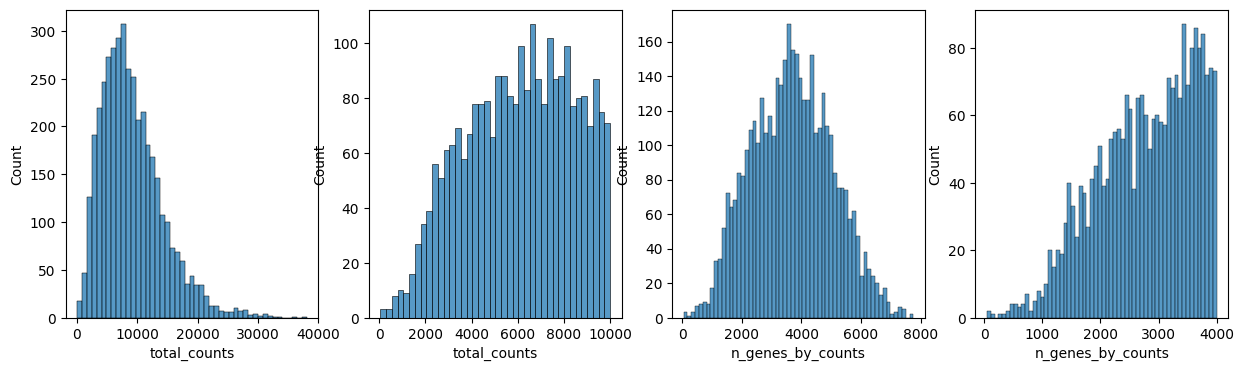

In [75]:
fig, axs = plt.subplots(1, 4, figsize=(15, 4))
sns.histplot(adata.obs["total_counts"], kde=False, ax=axs[0])
sns.histplot(
    adata.obs["total_counts"][adata.obs["total_counts"] < 10000],
    kde=False,
    bins=40,
    ax=axs[1],
)
sns.histplot(adata.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[2])
sns.histplot(
    adata.obs["n_genes_by_counts"][adata.obs["n_genes_by_counts"] < 4000],
    kde=False,
    bins=60,
    ax=axs[3],
)

In [76]:
sc.pp.filter_cells(adata, min_counts=5000)
sc.pp.filter_cells(adata, max_counts=35000)
adata = adata[adata.obs["pct_counts_mt"] < 20].copy()
print(f"#cells after MT filter: {adata.n_obs}")
sc.pp.filter_genes(adata, min_cells=10)

#cells after MT filter: 3226


In [77]:
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=2000)

In [78]:
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(
    adata, key_added="clusters", directed=False, n_iterations=2
)

C:\Users\masmel\AppData\Local\anaconda3\envs\COMMOT4\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


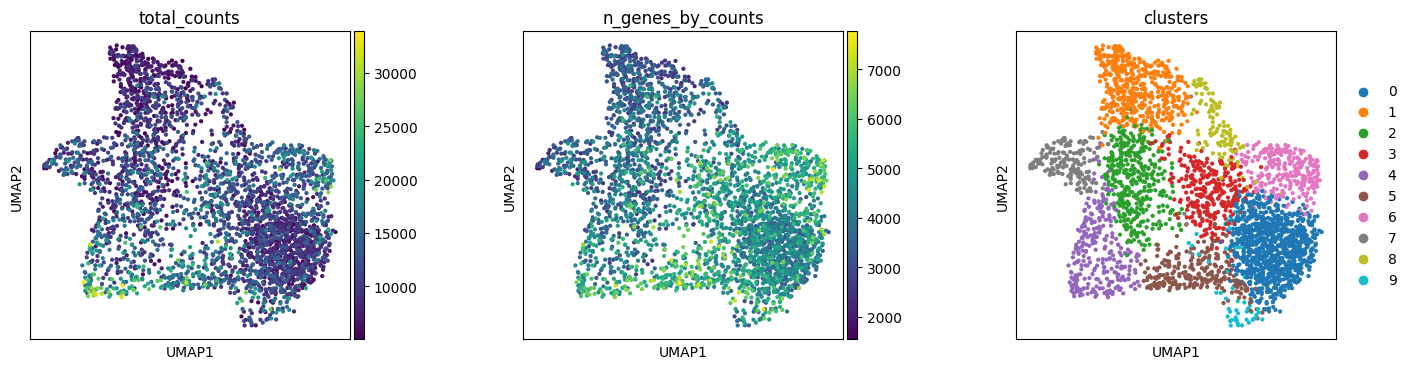

In [79]:
plt.rcParams["figure.figsize"] = (4, 4)
sc.pl.umap(adata, color=["total_counts", "n_genes_by_counts", "clusters"], wspace=0.4)

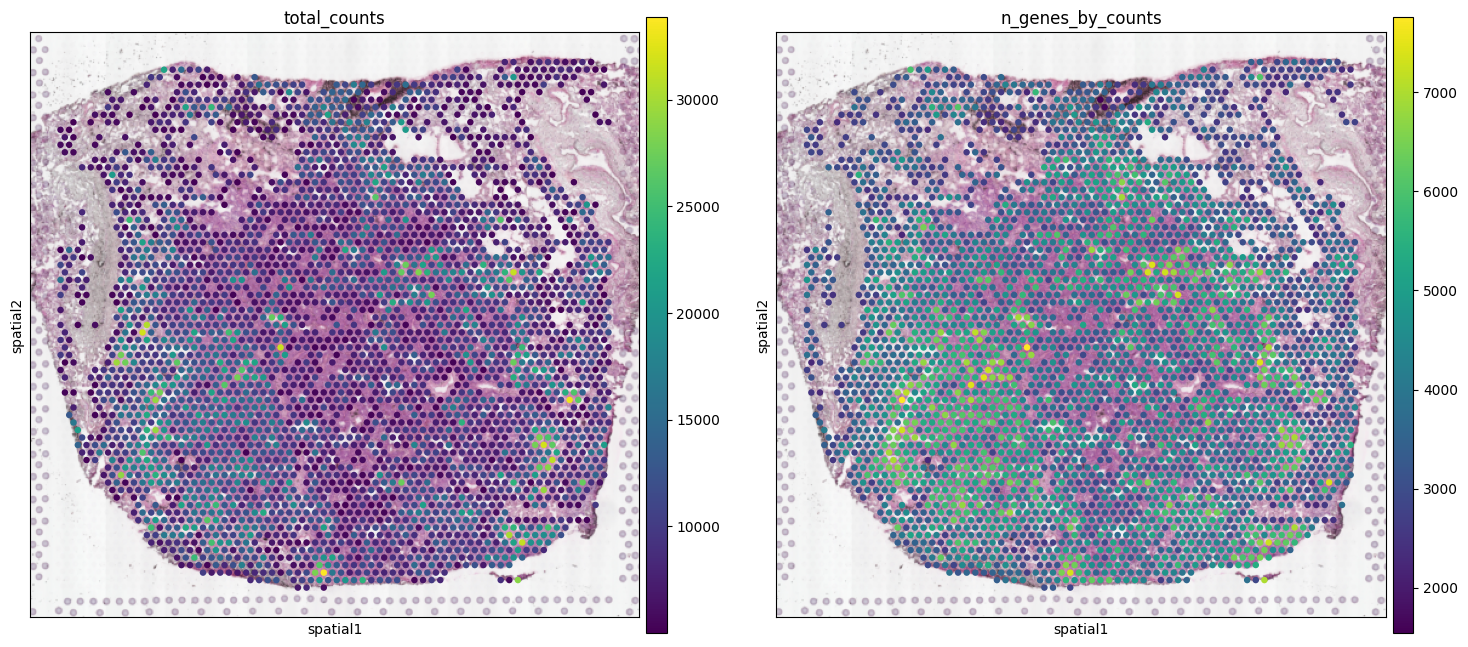

In [80]:
plt.rcParams["figure.figsize"] = (8, 8)
sc.pl.spatial(adata, img_key="hires", color=["total_counts", "n_genes_by_counts"])

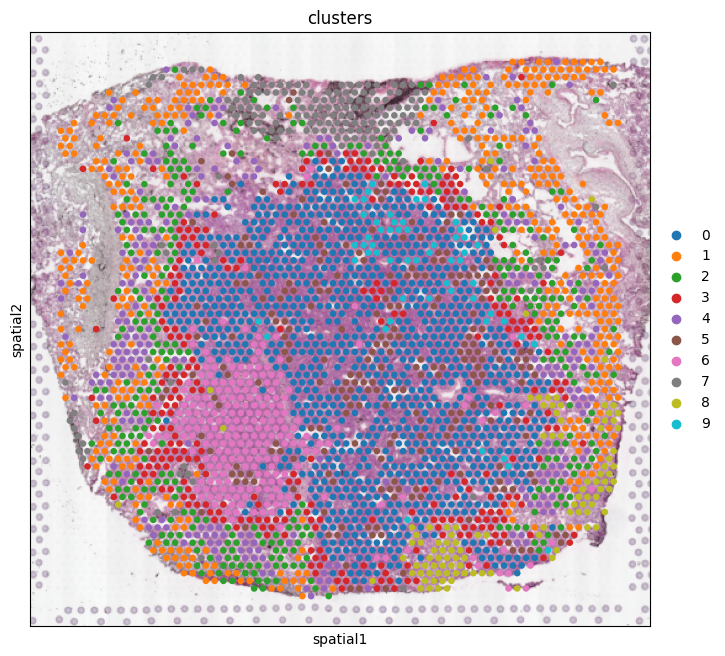

In [81]:
sc.pl.spatial(adata, img_key="hires", color="clusters", size=1)